In [106]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [107]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'])

In [108]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [109]:
sales_a.shape

(60, 2)

In [110]:
sales_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [111]:
sales_a['Sales'].sum()

3213992

In [112]:
sales_a = sales_a.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_a.head(5)

,ds,y
0,2019-01-01,54555
1,2019-02-01,54293
2,2019-03-01,58798
3,2019-04-01,53229
4,2019-05-01,50558


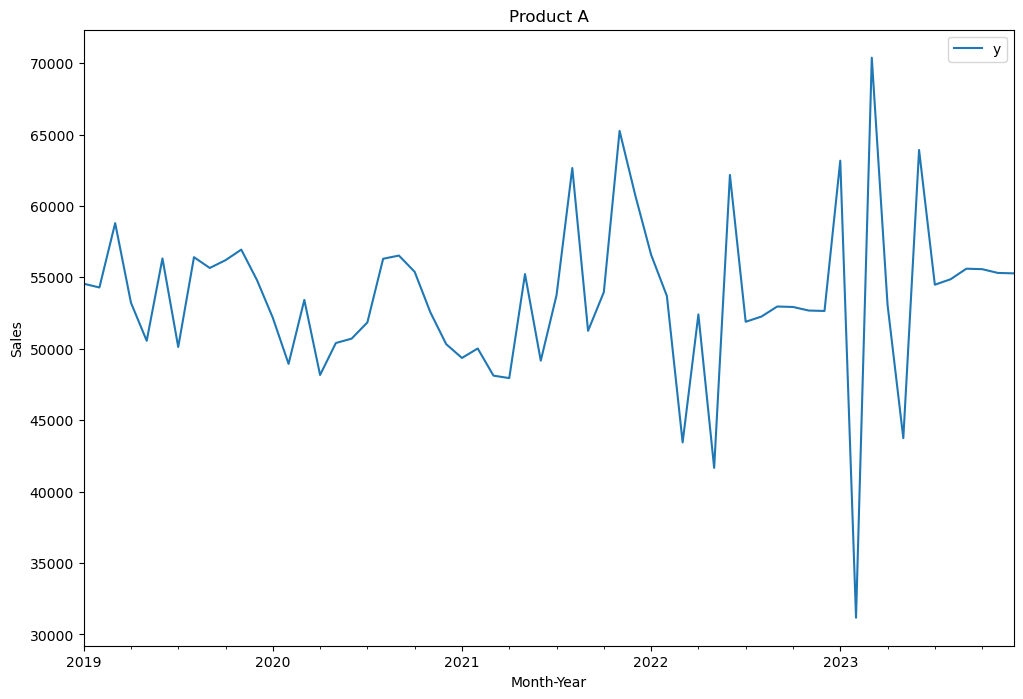

In [113]:
ax = sales_a.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product A')
plt.show()

In [114]:
train= sales_a[:54]
test=sales_a[54:]

# Hyperparameter Tuning

In [115]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:18:27 - cmdstanpy - INFO - Chain [1] start processing
16:18:28 - cmdstanpy - INFO - Chain [1] done processing
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:34 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:46 - cmdstanpy - INFO - Chain [1] start processing
16:18:47 - cmdstanpy - INFO - Chain [1] done processing
16:18:51 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing
16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:00 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:04 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0    8992.087352  
1    8978.149820  
2    8926.563018  
3    9005.741078  
4    8673.315407  
..       

In [116]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
11,0.001,10.00,multiplicative,8570.925960
8,0.001,5.00,additive,8623.564406
18,0.010,3.00,additive,8624.821244
20,0.010,5.00,additive,8631.249515
22,0.010,10.00,additive,8632.374074
...,...,...,...,...
69,0.500,5.00,multiplicative,10452.296397
48,0.300,0.01,additive,10479.681165
49,0.300,0.01,multiplicative,10608.855910
60,0.500,0.01,additive,10889.026953


In [117]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [118]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=10.0, seasonality_mode = 'multiplicative',
                interval_width=0.95)

In [119]:
model.fit(train)

16:23:38 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 6 months in 2023

In [121]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [122]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [123]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
54,2023-07-01,49872.501601,41096.855333,58994.628724
55,2023-08-01,55126.859031,46123.062732,64347.457345
56,2023-09-01,54187.285235,44857.311986,62787.963830
57,2023-10-01,55118.717069,46175.865466,63989.360438
58,2023-11-01,56970.998668,47576.321993,66596.008184
59,2023-12-01,54790.076275,45258.269628,63819.663377


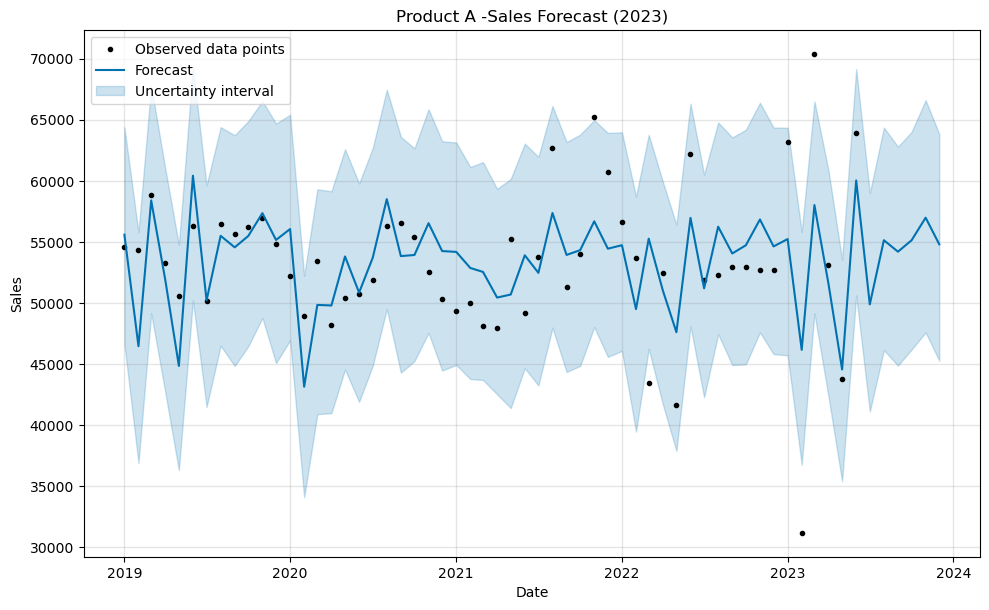

In [124]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

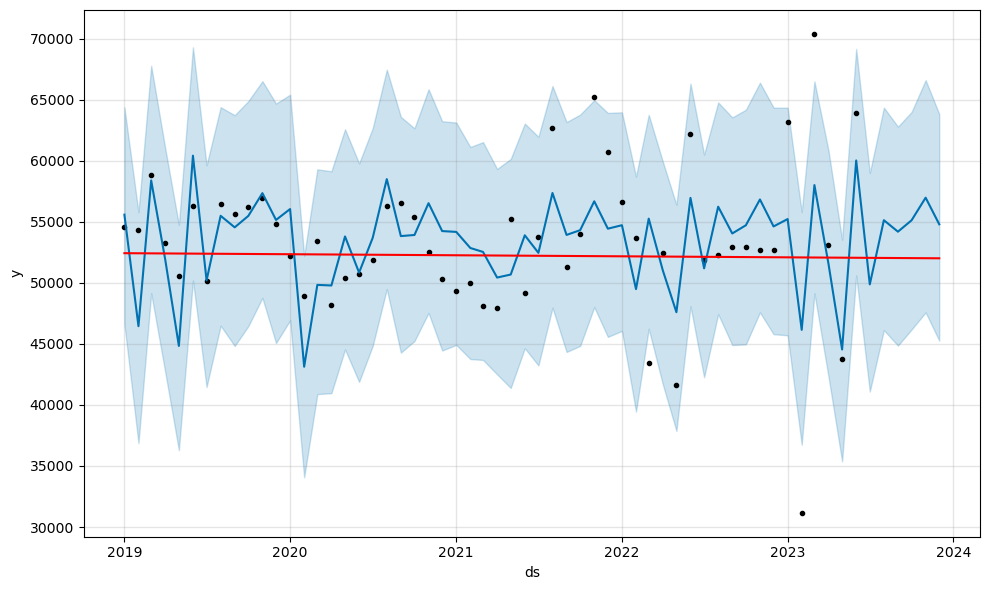

In [125]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

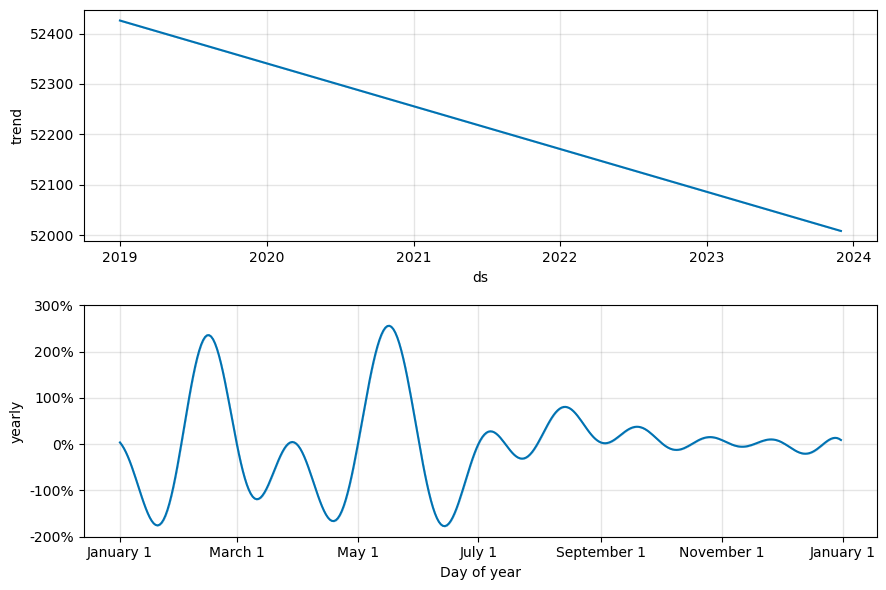

In [126]:
fig2 = model.plot_components(forecast)

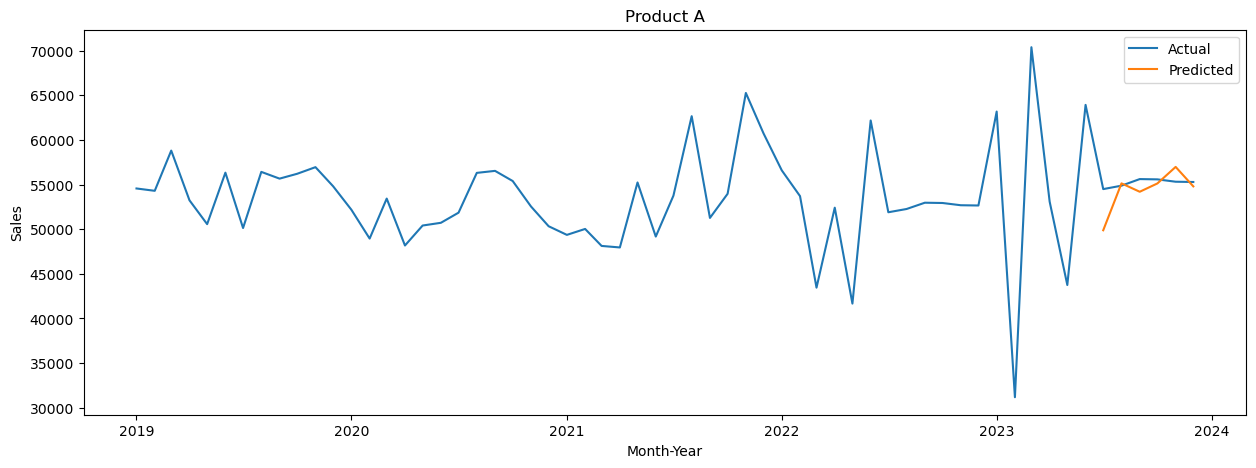

In [127]:
# Reset index of sales_b DataFrame
sales_a_reset_index = sales_a.reset_index()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(sales_a_reset_index['ds'], sales_a_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product A')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [128]:
#model evaluation

In [129]:
pred=forecasted_df['yhat']
test_df=test['y']

In [130]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 1482.880
MAPE - FB PROPHET: 0.027
MSE - FB PROPHET: 4427003.095
RMSE - FB PROPHET: 2104.044


In [131]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

In [132]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [133]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,2.856036e+07,5344.189387,5344.026320,0.096951,0.096951,0.101896,0.0
1,25 days,1.515898e+07,3893.453758,3393.400718,0.061157,0.061157,0.063667,0.5
2,29 days,6.730137e+07,8203.741488,6495.498468,0.105379,0.105379,0.114712,0.5
3,51 days,1.116996e+08,10568.804277,10522.940986,0.167200,0.167200,0.182599,0.0
4,55 days,4.797872e+07,6926.667157,5882.934515,0.096858,0.096858,0.103569,0.5
5,56 days,1.421743e+07,3770.600909,3535.921836,0.067093,0.067093,0.065478,1.0
6,60 days,1.806926e+08,13442.195872,11613.821973,0.341252,0.341252,0.272041,0.5
7,82 days,1.705543e+08,13059.644638,10085.712998,0.312343,0.312343,0.244887,0.5
8,83 days,5.049404e+07,7105.915559,5838.946913,0.131269,0.131269,0.119339,0.5
9,87 days,4.915216e+07,7010.859902,5304.000454,0.120606,0.120606,0.108930,0.5


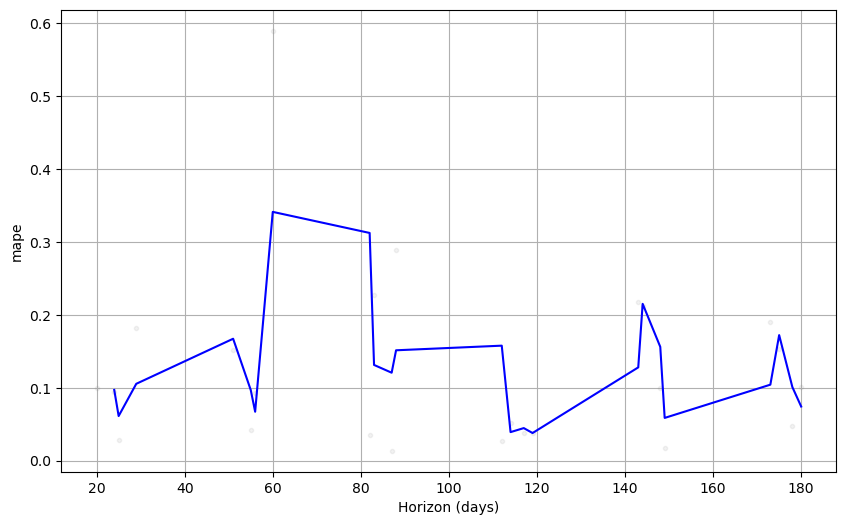

In [134]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [135]:
test_df

54    54485
55    54869
56    55607
57    55575
58    55311
59    55281
Name: y, dtype: int64

In [136]:
pred

54    49872.501601
55    55126.859031
56    54187.285235
57    55118.717069
58    56970.998668
59    54790.076275
Name: yhat, dtype: float64

# FORECASTING

In [137]:
model_forecast = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=10.0, seasonality_mode = 'multiplicative',
                interval_width=0.95)

In [138]:
model_forecast.fit(sales_a)

16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing


In [139]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=6, freq='MS')  # 6 months in 2024

In [140]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [141]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [142]:
forecasted_f_df

,ds,yhat,yhat_lower,yhat_upper
60,2024-01-01,56204.589499,46698.922612,65310.280262
61,2024-02-01,44754.605883,36656.884361,53789.331044
62,2024-03-01,50752.868110,41396.372914,59796.334459
63,2024-04-01,50337.399542,41634.729197,59887.327661
64,2024-05-01,54353.545942,44773.891549,63731.517248
65,2024-06-01,50920.314049,41275.475956,59715.576696


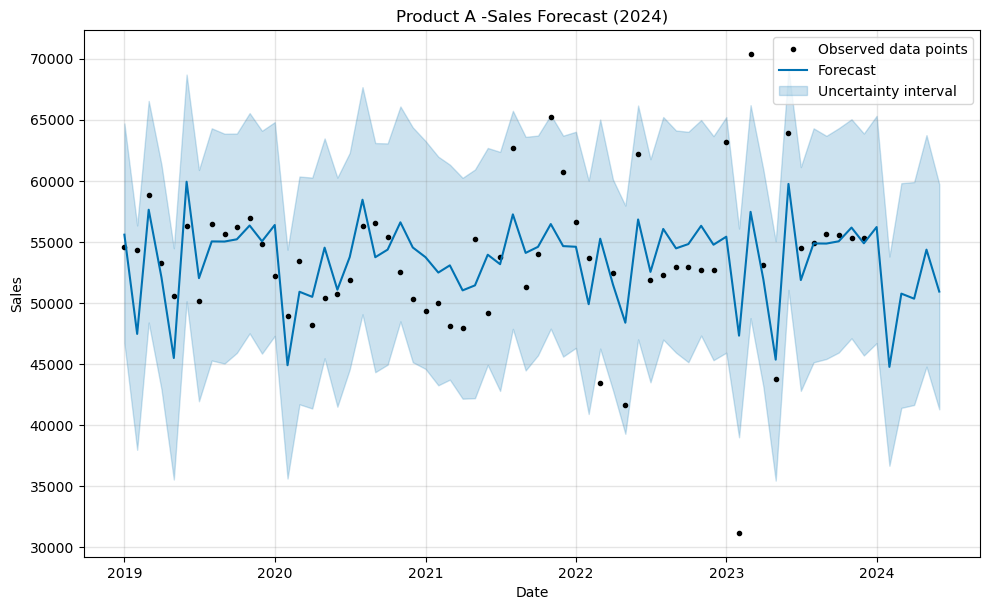

In [143]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [144]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [145]:
plot_components_plotly(model_forecast, forecast_f)
